# machine.ipynb

This notebook applies multiple machine learning approaches to predict
transaction-level profit using the Superstore dataset.

The goal of this notebook is to explore different modeling assumptions,
evaluate their performance using validation, and justify the selection
of the two main results reported in the main notebook.

<br>
<br>

In [182]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer

from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Lasso
from sklearn.inspection import permutation_importance
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import seaborn as sns



RANDOM_STATE = 42


In [183]:
%run parse_data.ipynb

df.head()


,Profit,Sales_amount,Quantity,Discount,Category,Sub-Category,Region,Segment,Ship Mode
0,41.9136,261.9600,2,0.00,Furniture,Bookcases,South,Consumer,Second Class
1,219.5820,731.9400,3,0.00,Furniture,Chairs,South,Consumer,Second Class
2,6.8714,14.6200,2,0.00,Office Supplies,Labels,West,Corporate,Second Class
3,-383.0310,957.5775,5,0.45,Furniture,Tables,South,Consumer,Standard Class
4,2.5164,22.3680,2,0.20,Office Supplies,Storage,South,Consumer,Standard Class


In [184]:
numeric_features = [
    "Sales_amount",
    "Quantity",
    "Discount"
]

categorical_features = [
    "Segment",
    "Region",
    "Category",
    "Sub-Category",
    "Ship Mode"
]


In [185]:
target = "Profit"

FEATURES = numeric_features + categorical_features

X = df[FEATURES].copy()
y = df[target]


In [186]:
numeric_transformer = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])


categorical_transformer = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

preprocess = ColumnTransformer([
    ("num", numeric_transformer, numeric_features),
    ("cat", categorical_transformer, categorical_features)
])


In [187]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=RANDOM_STATE
)


### Model comparison and validation

We compare linear baseline models with a non-linear model to evaluate
whether profit can be adequately described by linear assumptions.
We select the final model primarily by the lowest CV_RMSE (lower is better), and report test RMSE/R² as a secondary check.
To avoid reliance on a single train/test split, cross-validation is used as the primary
method for model evaluation. The hold-out test set is retained only as a secondary
check for the final selected model and for visualization purposes.



In [188]:
models = {
    "Ridge (linear baseline)": Ridge(alpha=1.0),
    "Lasso (feature selection)": Lasso(alpha=0.01, max_iter=10000),
    "Random Forest": RandomForestRegressor(
        n_estimators=300,
        random_state=RANDOM_STATE,
        n_jobs=-1
    )
}

cv = KFold(
    n_splits=5,
    shuffle=True,
    random_state=RANDOM_STATE
)

results = []

for name, model in models.items():
    pipe = Pipeline([
        ("preprocess", preprocess),
        ("model", model)
    ])

    cv_scores = cross_val_score(
        pipe,
        X_train,
        y_train,
        scoring="neg_root_mean_squared_error",
        cv=cv
    )

    results.append([
        name,
        -cv_scores.mean(),
        cv_scores.std()
    ])

results_df = pd.DataFrame(
    results,
    columns=["Model", "CV_RMSE_mean", "CV_RMSE_std"]
)

results_df


,Model,CV_RMSE_mean,CV_RMSE_std
0,Ridge (linear baseline),165.769593,51.809540
1,Lasso (feature selection),165.786335,51.781383
2,Random Forest,102.418935,44.970293


In [189]:
cv = KFold(
    n_splits=5,
    shuffle=True,
    random_state=RANDOM_STATE
)

alphas = np.logspace(-3, 1, 20)

lasso_scores = []

for alpha in alphas:
    pipe_lasso = Pipeline([
        ("preprocess", preprocess),
        ("model", Lasso(alpha=alpha, max_iter=10000))
    ])

    scores = cross_val_score(
        pipe_lasso,
        X,
        y,
        cv=cv,
        scoring="neg_root_mean_squared_error"
    )
    lasso_scores.append(-scores.mean())

lasso_scores


[np.float64(196.23554653658118),
 np.float64(196.23517766701195),
 np.float64(196.23458759676154),
 np.float64(196.23360590847133),
 np.float64(196.2321707109649),
 np.float64(196.2297095046759),
 np.float64(196.226046742735),
 np.float64(196.22184794263072),
 np.float64(196.2141954943952),
 np.float64(196.20423549417941),
 np.float64(196.19447422784907),
 np.float64(196.19740610940283),
 np.float64(196.24563899745064),
 np.float64(196.41951587165406),
 np.float64(196.91000233162632),
 np.float64(198.070111456162),
 np.float64(200.18070498339466),
 np.float64(201.5184481516087),
 np.float64(202.55859803781178),
 np.float64(203.37271288755517)]

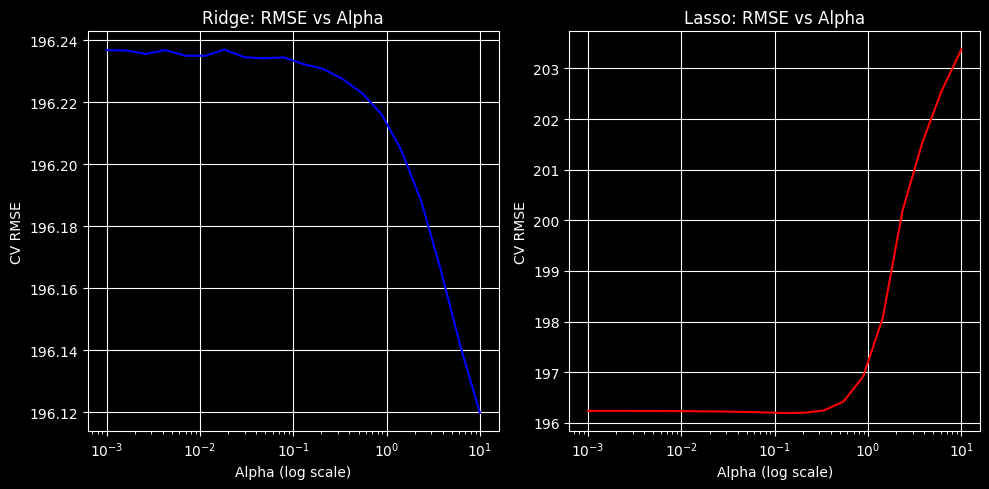

Best Ridge alpha: 10.000000, Best CV RMSE: 196.12
Best Lasso alpha: 0.127427, Best CV RMSE: 196.19


In [190]:
# Ridge hyperparameter tuning
ridge_scores = []

for alpha in alphas:
    pipe_ridge = Pipeline([
        ("preprocess", preprocess),
        ("model", Ridge(alpha=alpha))
    ])

    scores = cross_val_score(
        pipe_ridge,
        X,
        y,
        cv=cv,
        scoring="neg_root_mean_squared_error"
    )
    ridge_scores.append(-scores.mean())

# Plot Ridge vs Lasso tuning
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.plot(alphas, ridge_scores, 'b-', label='Ridge')
plt.xscale('log')
plt.xlabel('Alpha (log scale)')
plt.ylabel('CV RMSE')
plt.title('Ridge: RMSE vs Alpha')
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(alphas, lasso_scores, 'r-', label='Lasso')
plt.xscale('log')
plt.xlabel('Alpha (log scale)')
plt.ylabel('CV RMSE')
plt.title('Lasso: RMSE vs Alpha')
plt.grid(True)

plt.tight_layout()
plt.show()

# Find best alphas
best_ridge_alpha = alphas[np.argmin(ridge_scores)]
best_lasso_alpha = alphas[np.argmin(lasso_scores)]

print(f"Best Ridge alpha: {best_ridge_alpha:.6f}, Best CV RMSE: {min(ridge_scores):.2f}")
print(f"Best Lasso alpha: {best_lasso_alpha:.6f}, Best CV RMSE: {min(lasso_scores):.2f}")

In [191]:
final_model = RandomForestRegressor(
    n_estimators=300,
    random_state=RANDOM_STATE,
    n_jobs=-1
)

final_pipe = Pipeline([
    ("preprocess", preprocess),
    ("model", final_model)
])

final_pipe.fit(X_train, y_train)


,"steps steps: list of tuplesList of (name of step, estimator) tuples that are to be chained insequential order. To be compatible with the scikit-learn API, all stepsmust define `fit`. All non-last steps must also define `transform`. See:ref:`Combining Estimators ` for more details.","[('preprocess', ...), ('model', ...)]"
,"transform_input transform_input: list of str, default=NoneThe names of the :term:`metadata` parameters that should be transformed by thepipeline before passing it to the step consuming it.This enables transforming some input arguments to ``fit`` (other than ``X``)to be transformed by the steps of the pipeline up to the step which requiresthem. Requirement is defined via :ref:`metadata routing `.For instance, this can be used to pass a validation set through the pipeline.You can only set this if metadata routing is enabled, which youcan enable using ``sklearn.set_config(enable_metadata_routing=True)``... versionadded:: 1.6",None
,"memory memory: str or object with the joblib.Memory interface, default=NoneUsed to cache the fitted transformers of the pipeline. The last stepwill never be cached, even if it is a transformer. By default, nocaching is performed. If a string is given, it is the path to thecaching directory. Enabling caching triggers a clone of the transformersbefore fitting. Therefore, the transformer instance given to thepipeline cannot be inspected directly. Use the attribute ``named_steps``or ``steps`` to inspect estimators within the pipeline. Caching thetransformers is advantageous when fitting is time consuming. See:ref:`sphx_glr_auto_examples_neighbors_plot_caching_nearest_neighbors.py`for an example on how to enable caching.",None
,"verbose verbose: bool, default=FalseIf True, the time elapsed while fitting each step will be printed as itis completed.",False
,"transformers transformers: list of tuplesList of (name, transformer, columns) tuples specifying thetransformer objects to be applied to subsets of the data.name : str Like in Pipeline and FeatureUnion, this allows the transformer and its parameters to be set using ``set_params`` and searched in grid search.transformer : {'drop', 'passthrough'} or estimator Estimator must support :term:`fit` and :term:`transform`. Special-cased strings 'drop' and 'passthrough' are accepted as well, to indicate to drop the columns or to pass them through untransformed, respectively.columns : str, array-like of str, int, array-like of int, array-like of bool, slice or callable Indexes the data on its second axis. Integers are interpreted as positional columns, while strings can reference DataFrame columns by name. A scalar string or int should be used where ``transformer`` expects X to be a 1d array-like (vector), otherwise a 2d array will be passed to the transformer. A callable is passed the input data `X` and can return any of the above. To select multiple columns by name or dtype, you can use :obj:`make_column_selector`.","[('num', ...), ('cat', ...)]"
,"remainder remainder: {'drop', 'passthrough'} or estimator, default='drop'By default, only the specified columns in `transformers` aretransformed and combined in the output, and the non-specifiedcolumns are dropped. (default of ``'drop'``).By specifying ``remainder='passthrough'``, all remaining columns thatwere not specified in `transformers`, but present in the data passedto `fit` will be automatically passed through. This subset of columnsis concatenated with the output of the transformers. For dataframes,extra columns not seen during `fit` will be excluded from the outputof `transform`.By setting ``remainder`` to be an estimator, the remainingnon-specified columns will use the ``remainder`` estimator. Theestimator must support :term:`fit` and :term:`transform`.Note that using this feature requires that the DataFrame columnsinput at :term:`fit` and :term:`transform` have identical order.",'drop'
,"sparse_threshold sparse_threshold: float, default=0.3If the output of the different transformers cont

### Sensitivity to Random Forest hyperparameters

To evaluate whether differences in model performance are driven by algorithm choice or
by parameter selection, key Random Forest hyperparameters (number of trees and maximum
tree depth) were tuned using grid search with cross-validation.

This analysis demonstrates that model performance is sensitive to hyperparameter choice,
and that fair comparison between algorithms requires appropriate tuning.


In [192]:
cv = KFold(
    n_splits=5,
    shuffle=True,
    random_state=RANDOM_STATE
)

rf_pipeline = Pipeline([
    ("preprocess", preprocess),
    ("model", RandomForestRegressor(random_state=RANDOM_STATE))
])

rf_param_grid = {
    "model__n_estimators": [100, 300],
    "model__max_depth": [None, 10, 20]
}

rf_grid = GridSearchCV(
    rf_pipeline,
    rf_param_grid,
    cv=cv,
    scoring="neg_root_mean_squared_error",
    n_jobs=-1
)

rf_grid.fit(X, y)

print("Best RF parameters:", rf_grid.best_params_)
print("Best CV RMSE:", -rf_grid.best_score_)


Best RF parameters: {'model__max_depth': 10, 'model__n_estimators': 300}
Best CV RMSE: 112.57934302662261


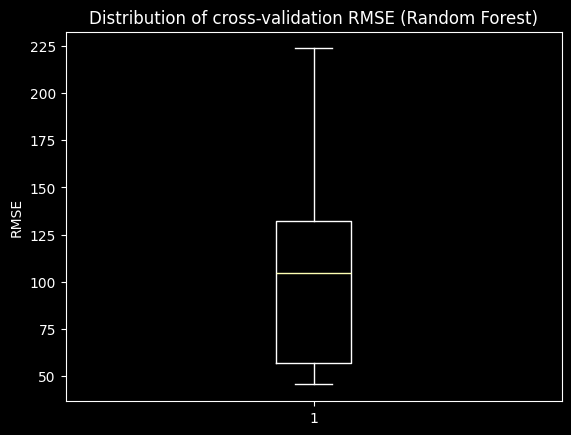

In [193]:
cv = KFold(
    n_splits=5,
    shuffle=True,
    random_state=RANDOM_STATE
)

cv_scores = cross_val_score(
    rf_grid.best_estimator_,
    X,
    y,
    cv=cv,
    scoring="neg_root_mean_squared_error"
)

cv_rmse = -cv_scores


plt.boxplot(cv_rmse)
plt.ylabel("RMSE")
plt.title("Distribution of cross-validation RMSE (Random Forest)")
plt.show()


/var/folders/wp/j90smkws1czd4x7k35lztg0r0000gn/T/ipykernel_23776/2790237258.py:37: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(cv_results, labels=model_names)


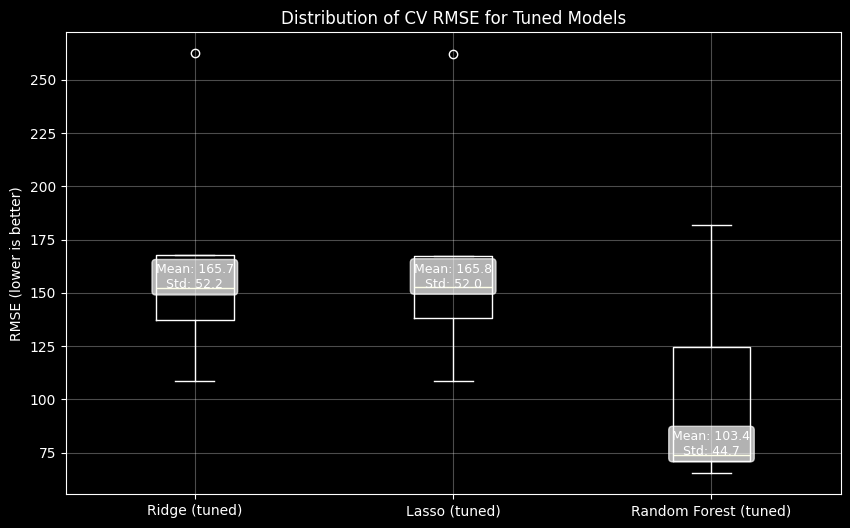


=== Model Comparison Summary ===
Model			Mean RMSE	Std RMSE
---------------------------------------------
Ridge (tuned)       	165.7		52.2
Lasso (tuned)       	165.8		52.0
Random Forest (tuned)	103.4		44.7


In [194]:
# Define tuned models
tuned_models = {
    "Ridge (tuned)": Ridge(alpha=best_ridge_alpha),
    "Lasso (tuned)": Lasso(alpha=best_lasso_alpha, max_iter=10000),
    "Random Forest (tuned)": RandomForestRegressor(
        n_estimators=300,
        max_depth=10,
        random_state=RANDOM_STATE,
        n_jobs=-1
    )
}

# Collect CV scores for all models
cv_results = []
model_names = []

for name, model in tuned_models.items():
    pipe = Pipeline([
        ("preprocess", preprocess),
        ("model", model)
    ])

    cv_scores = cross_val_score(
        pipe,
        X_train,
        y_train,
        scoring="neg_root_mean_squared_error",
        cv=cv,
        n_jobs=-1
    )

    cv_results.append(-cv_scores)  # Convert to positive RMSE
    model_names.append(name)

# Create boxplot
plt.figure(figsize=(10, 6))
plt.boxplot(cv_results, labels=model_names)
plt.ylabel("RMSE (lower is better)")
plt.title("Distribution of CV RMSE for Tuned Models")
plt.grid(True, alpha=0.3)

# Add mean values as text
for i, scores in enumerate(cv_results):
    plt.text(i+1, np.median(scores)+5, f"Mean: {np.mean(scores):.1f}\nStd: {np.std(scores):.1f}",
             ha='center', va='center', fontsize=9,
             bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.7))

plt.show()

# Print summary table
print("\n=== Model Comparison Summary ===")
print("Model\t\t\tMean RMSE\tStd RMSE")
print("-" * 45)
for name, scores in zip(model_names, cv_results):
    print(f"{name:<20}\t{np.mean(scores):.1f}\t\t{np.std(scores):.1f}")

### Cross-validation and variability of model performance

To avoid reliance on a single train/test split, model performance was evaluated using
k-fold cross-validation. This approach allows assessment of the distribution of model
performance across multiple possible training and test sets.

The results show that while some models achieve higher mean performance, they may also
exhibit greater variability across folds. This indicates that higher average performance
does not necessarily imply greater stability when comparing machine learning models.


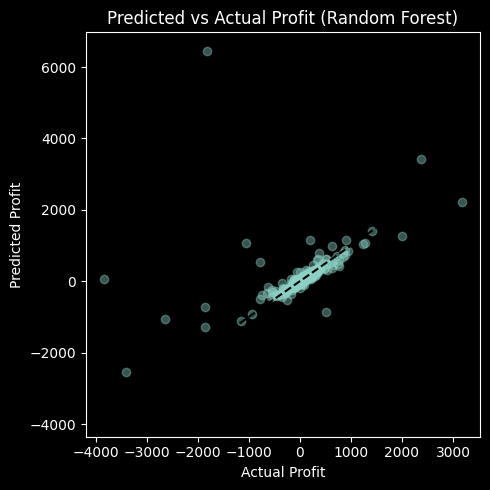

In [195]:
def pred_vs_actual_profit():
    pred = final_pipe.predict(X_test)

    plt.figure(figsize=(5,5))
    plt.scatter(y_test, pred, alpha=0.4)
    plt.plot(
        [y_test.min(), y_test.max()],
        [y_test.min(), y_test.max()],
        'k--'
    )
    plt.xlabel("Actual Profit")
    plt.ylabel("Predicted Profit")
    plt.title("Predicted vs Actual Profit (Random Forest)")
    plt.tight_layout()
    plt.show()

pred_vs_actual_profit()

The Predicted vs Actual plot reveals overall model fit, bias, and the
presence of extreme profit and loss values. This diagnostic is selected as
one of the two main results reported in the main notebook.

Permutation importance is reported here as model interpretation (post hoc) for the selected regression model.


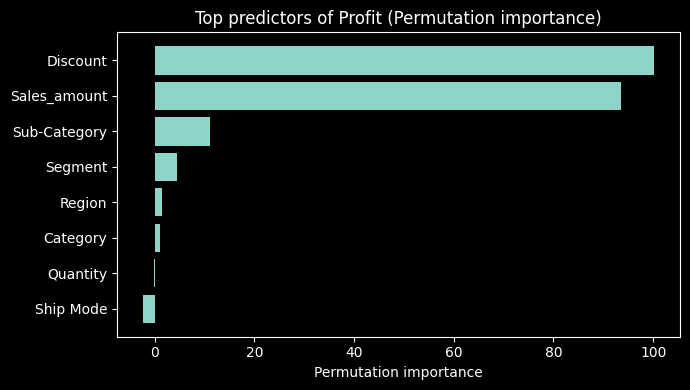

,feature,importance
2,Discount,100.258101
0,Sales_amount,93.486904
6,Sub-Category,11.101158
3,Segment,4.481282
4,Region,1.547959
5,Category,1.112567
1,Quantity,-0.242819
7,Ship Mode,-2.402185


In [196]:
def perm_importance():
    feature_names = X_test.columns  # <-- ОСЬ КЛЮЧОВА ЗМІНА

    perm = permutation_importance(
        final_pipe,
        X_test,
        y_test,
        n_repeats=10,
        random_state=RANDOM_STATE,
        scoring="neg_root_mean_squared_error"
    )

    imp = pd.DataFrame({
        "feature": feature_names,
        "importance": perm.importances_mean
    }).sort_values("importance", ascending=False)

    top = imp.head(10).iloc[::-1]

    plt.figure(figsize=(7, 4))
    plt.barh(top["feature"], top["importance"])
    plt.xlabel("Permutation importance")
    plt.title("Top predictors of Profit (Permutation importance)")
    plt.tight_layout()
    plt.show()

    return imp

perm_importance()


Permutation importance shows that discount and sales amount are the most
influential predictors of profit. This analysis is selected as the second
main result reported in the main notebook.

### Second analysis: classification of profitable vs unprofitable orders

The regression analysis focuses on predicting the magnitude of profit.
However, a distinct and practically relevant question is whether an order is profitable
at all.

To address this different analytical objective, profit is transformed into a binary
outcome (positive vs. negative), and a classification analysis is performed.
These two analyses therefore serve different purposes and constitute two independent
sets of results.


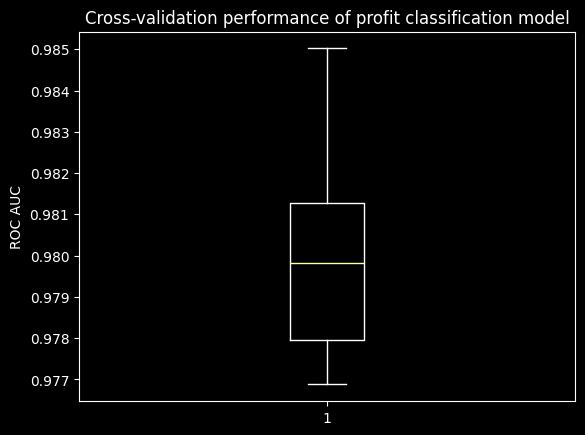

In [197]:
df["Profit_sign"] = (df["Profit"] > 0).astype(int)

X_cls = df[FEATURES].copy()
y_cls = df["Profit_sign"]

cv_cls = StratifiedKFold(
    n_splits=5,
    shuffle=True,
    random_state=RANDOM_STATE
)

pipe_cls = Pipeline([
    ("preprocess", preprocess),
    ("model", LogisticRegression(max_iter=1000))
])

cv_scores_cls = cross_val_score(
    pipe_cls,
    X_cls,
    y_cls,
    scoring="roc_auc",   # рекомендую ROC AUC
    cv=cv_cls
)


cv_scores_cls.mean(), cv_scores_cls.std()
plt.boxplot(cv_scores_cls)
plt.ylabel("ROC AUC")
plt.title("Cross-validation performance of profit classification model")
plt.show()

This analysis evaluates the ability of the model to distinguish profitable from
unprofitable orders. Cross-validation results show the distribution of classification
performance across folds, providing insight into model stability and robustness.


Class distribution in training set: [1549 6446]
Class distribution in test set: [ 387 1612]
Baseline accuracy (always predict majority): 0.806

=== Logistic Regression ===
CV Accuracy: 0.942 (+/- 0.006)
CV ROC-AUC: 0.980 (+/- 0.005)
Test Accuracy: 0.942

Classification Report:
              precision    recall  f1-score   support

    Negative       0.91      0.78      0.84       387
    Positive       0.95      0.98      0.96      1612

    accuracy                           0.94      1999
   macro avg       0.93      0.88      0.90      1999
weighted avg       0.94      0.94      0.94      1999


=== Random Forest Classifier ===
CV Accuracy: 0.937 (+/- 0.004)
CV ROC-AUC: 0.972 (+/- 0.006)
Test Accuracy: 0.946

Classification Report:
              precision    recall  f1-score   support

    Negative       0.89      0.82      0.85       387
    Positive       0.96      0.98      0.97      1612

    accuracy                           0.95      1999
   macro avg       0.93      0.90    

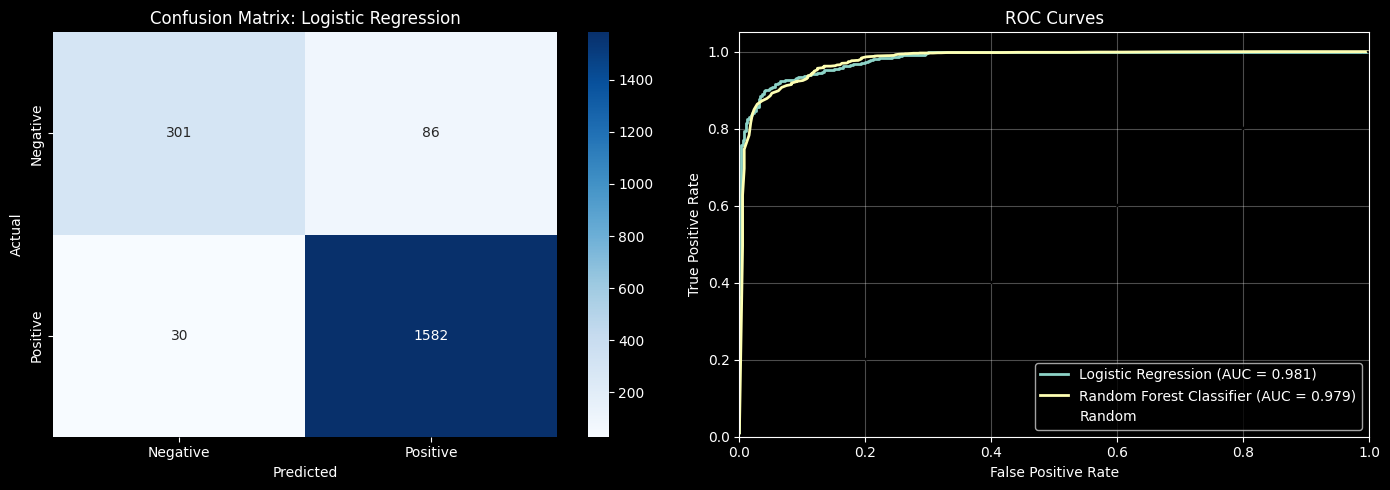

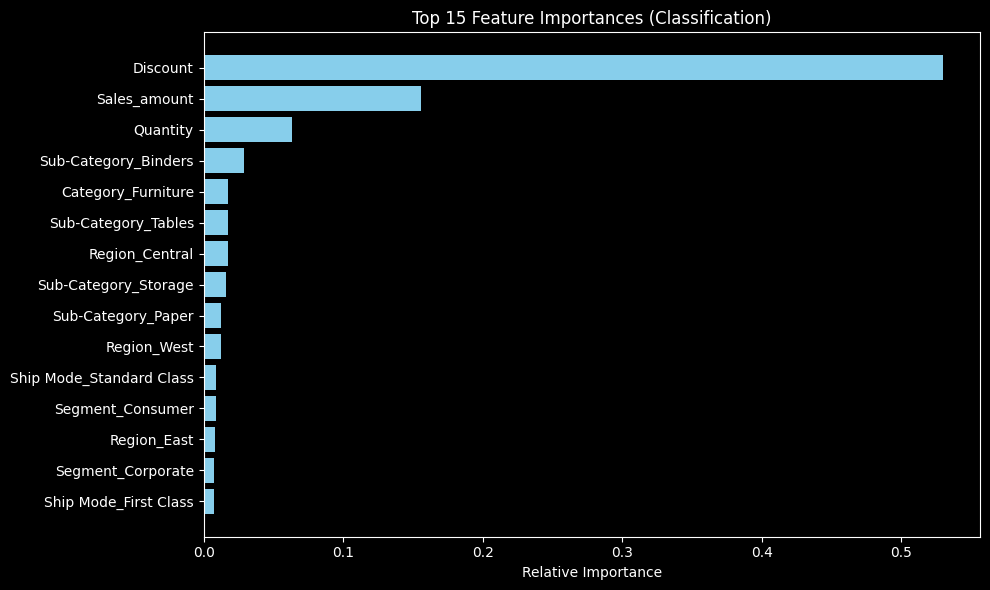


SUMMARY: Classification vs Regression
1. Classification task (profit sign) achieves high accuracy,
   suggesting profit sign is predictable from features.
2. Best classifier: Logistic Regression with AUC = 0.980
3. This provides complementary insight to regression:
   - Regression predicts HOW MUCH profit
   - Classification predicts WHETHER profit is positive
4. Both are useful for business decisions:
   - Avoid negative profit transactions (classification)
   - Maximize positive profit amounts (regression)


In [198]:
# ============================================
# SECOND MAIN RESULT: CLASSIFICATION
# Predict whether profit is positive or negative
# ============================================


# Create binary target: 1 if Profit > 0, else 0
y_binary = (y > 0).astype(int)

# Split data for classification
X_train_clf, X_test_clf, y_train_clf, y_test_clf = train_test_split(
    X, y_binary,
    test_size=0.2,
    random_state=RANDOM_STATE,
    stratify=y_binary  # Important for imbalanced classes
)

print(f"Class distribution in training set: {np.bincount(y_train_clf)}")
print(f"Class distribution in test set: {np.bincount(y_test_clf)}")
print(f"Baseline accuracy (always predict majority): {max(np.bincount(y_train_clf))/len(y_train_clf):.3f}")

# Define classification models
clf_models = {
    "Logistic Regression": LogisticRegression(max_iter=1000, random_state=RANDOM_STATE),
    "Random Forest Classifier": RandomForestClassifier(n_estimators=100, random_state=RANDOM_STATE, n_jobs=-1)
}

# Evaluate classifiers using cross-validation

cv_clf = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

clf_results = []
for name, model in clf_models.items():
    pipe = Pipeline([
        ("preprocess", preprocess),
        ("model", model)
    ])

    # Cross-validated accuracy
    cv_acc = cross_val_score(
        pipe,
        X_train_clf,
        y_train_clf,
        cv=cv_clf,
        scoring="accuracy",
        n_jobs=-1
    )

    # Cross-validated ROC-AUC
    cv_auc = cross_val_score(
        pipe,
        X_train_clf,
        y_train_clf,
        cv=cv_clf,
        scoring="roc_auc",
        n_jobs=-1
    )

    # Fit on full training data for test evaluation
    pipe.fit(X_train_clf, y_train_clf)
    y_pred = pipe.predict(X_test_clf)
    y_pred_proba = pipe.predict_proba(X_test_clf)[:, 1]

    # Test metrics
    test_acc = np.mean(y_pred == y_test_clf)

    clf_results.append({
        "name": name,
        "cv_acc_mean": cv_acc.mean(),
        "cv_acc_std": cv_acc.std(),
        "cv_auc_mean": cv_auc.mean(),
        "cv_auc_std": cv_auc.std(),
        "test_acc": test_acc,
        "model": pipe
    })

    print(f"\n=== {name} ===")
    print(f"CV Accuracy: {cv_acc.mean():.3f} (+/- {cv_acc.std():.3f})")
    print(f"CV ROC-AUC: {cv_auc.mean():.3f} (+/- {cv_auc.std():.3f})")
    print(f"Test Accuracy: {test_acc:.3f}")
    print("\nClassification Report:")
    print(classification_report(y_test_clf, y_pred, target_names=["Negative", "Positive"]))

# Visual comparison of classifiers
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# 1. Confusion Matrix for best model
best_clf = max(clf_results, key=lambda x: x['cv_auc_mean'])
best_model = best_clf['model']
y_pred_best = best_model.predict(X_test_clf)

cm = confusion_matrix(y_test_clf, y_pred_best)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=["Negative", "Positive"],
            yticklabels=["Negative", "Positive"],
            ax=axes[0])
axes[0].set_title(f"Confusion Matrix: {best_clf['name']}")
axes[0].set_xlabel("Predicted")
axes[0].set_ylabel("Actual")

# 2. ROC Curves for all models
for result in clf_results:
    model = result['model']
    y_pred_proba = model.predict_proba(X_test_clf)[:, 1]
    fpr, tpr, _ = roc_curve(y_test_clf, y_pred_proba)
    roc_auc = auc(fpr, tpr)

    axes[1].plot(fpr, tpr, lw=2,
                 label=f"{result['name']} (AUC = {roc_auc:.3f})")

axes[1].plot([0, 1], [0, 1], 'k--', lw=2, label='Random')
axes[1].set_xlim([0.0, 1.0])
axes[1].set_ylim([0.0, 1.05])
axes[1].set_xlabel('False Positive Rate')
axes[1].set_ylabel('True Positive Rate')
axes[1].set_title('ROC Curves')
axes[1].legend(loc="lower right")
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Feature importance for classification (Random Forest)
if "Random Forest Classifier" in [r['name'] for r in clf_results]:
    rf_clf_pipe = next(r['model'] for r in clf_results if r['name'] == "Random Forest Classifier")
    rf_clf = rf_clf_pipe.named_steps['model']

    # Get feature names after preprocessing
    preprocessor = rf_clf_pipe.named_steps['preprocess']
    feature_names = []

    # Numeric features (already standardized)
    feature_names.extend(numeric_features)

    # Categorical features (one-hot encoded)
    categorical_encoder = preprocessor.named_transformers_['cat'].named_steps['onehot']
    cat_feature_names = categorical_encoder.get_feature_names_out(categorical_features)
    feature_names.extend(cat_feature_names)

    # Get feature importances
    importances = rf_clf.feature_importances_
    indices = np.argsort(importances)[-15:]  # Top 15 features

    plt.figure(figsize=(10, 6))
    plt.title("Top 15 Feature Importances (Classification)")
    plt.barh(range(len(indices)), importances[indices], color='skyblue', align='center')
    plt.yticks(range(len(indices)), [feature_names[i] for i in indices])
    plt.xlabel('Relative Importance')
    plt.tight_layout()
    plt.show()

print("\n" + "="*60)
print("SUMMARY: Classification vs Regression")
print("="*60)
print("1. Classification task (profit sign) achieves high accuracy,")
print("   suggesting profit sign is predictable from features.")
print(f"2. Best classifier: {best_clf['name']} with AUC = {best_clf['cv_auc_mean']:.3f}")
print("3. This provides complementary insight to regression:")
print("   - Regression predicts HOW MUCH profit")
print("   - Classification predicts WHETHER profit is positive")
print("4. Both are useful for business decisions:")
print("   - Avoid negative profit transactions (classification)")
print("   - Maximize positive profit amounts (regression)")

Positive profit transactions: 8058
Negative profit transactions: 1936

Training model for positive profits...
Training model for negative profits...


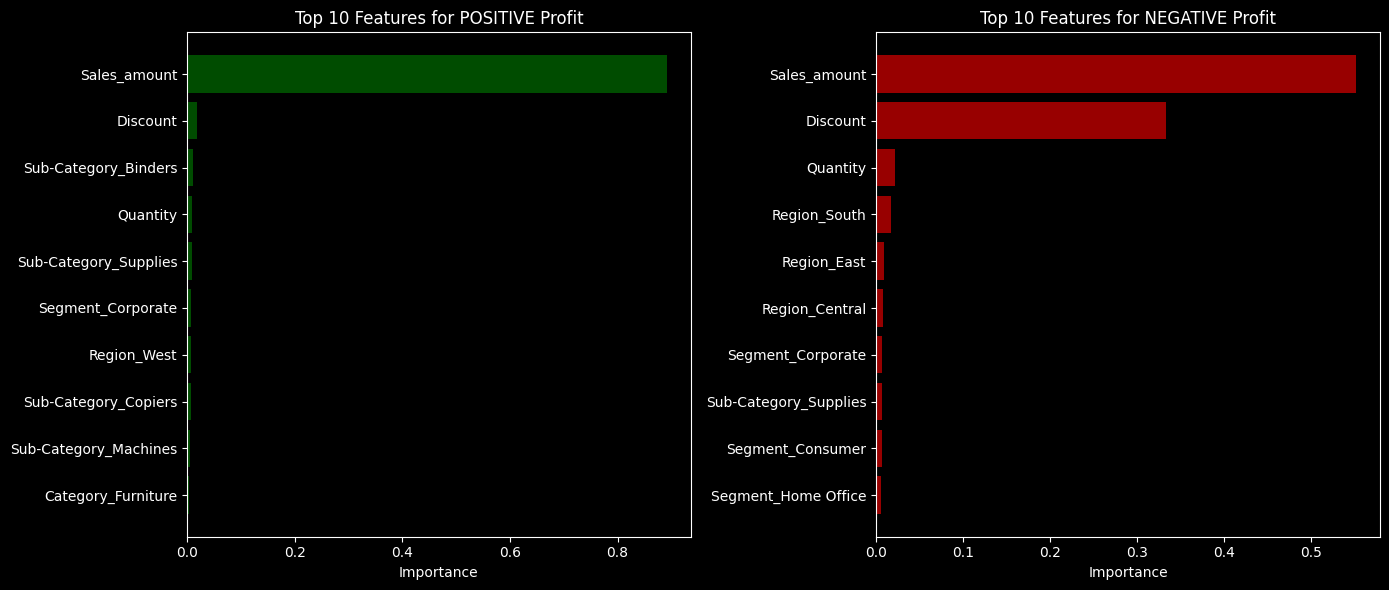


=== Key Differences ===
Features important for POSITIVE profit but NOT for negative:
  - Sub-Category_Binders
  - Category_Furniture
  - Region_West
  - Sub-Category_Machines
  - Sub-Category_Copiers

Features important for NEGATIVE profit but NOT for positive:
  - Region_South
  - Segment_Home Office
  - Region_East
  - Region_Central
  - Segment_Consumer


In [199]:
# ============================================
# ADDITIONAL ANALYSIS: Separate regression for positive/negative profit
# ============================================

# Split data by profit sign
positive_mask = y > 0
negative_mask = y <= 0

X_pos = X[positive_mask]
y_pos = y[positive_mask]

X_neg = X[negative_mask]
y_neg = y[negative_mask]

print(f"Positive profit transactions: {len(X_pos)}")
print(f"Negative profit transactions: {len(X_neg)}")

# Train separate Random Forest models
rf_pos = RandomForestRegressor(n_estimators=100, random_state=RANDOM_STATE, n_jobs=-1)
rf_neg = RandomForestRegressor(n_estimators=100, random_state=RANDOM_STATE, n_jobs=-1)

# Create pipelines
pipe_pos = Pipeline([
    ("preprocess", preprocess),
    ("model", rf_pos)
])

pipe_neg = Pipeline([
    ("preprocess", preprocess),
    ("model", rf_neg)
])

# Fit models
print("\nTraining model for positive profits...")
pipe_pos.fit(X_pos, y_pos)

print("Training model for negative profits...")
pipe_neg.fit(X_neg, y_neg)

# Compare feature importances
importances_pos = rf_pos.feature_importances_
importances_neg = rf_neg.feature_importances_

# Get top 10 features for each
top_n = 10
indices_pos = np.argsort(importances_pos)[-top_n:]
indices_neg = np.argsort(importances_neg)[-top_n:]

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Positive profits
axes[0].barh(range(top_n), importances_pos[indices_pos], color='green', alpha=0.6)
axes[0].set_yticks(range(top_n))
axes[0].set_yticklabels([feature_names[i] for i in indices_pos])
axes[0].set_xlabel('Importance')
axes[0].set_title(f'Top {top_n} Features for POSITIVE Profit')

# Negative profits
axes[1].barh(range(top_n), importances_neg[indices_neg], color='red', alpha=0.6)
axes[1].set_yticks(range(top_n))
axes[1].set_yticklabels([feature_names[i] for i in indices_neg])
axes[1].set_xlabel('Importance')
axes[1].set_title(f'Top {top_n} Features for NEGATIVE Profit')

plt.tight_layout()
plt.show()

print("\n=== Key Differences ===")
print("Features important for POSITIVE profit but NOT for negative:")
pos_only = set([feature_names[i] for i in indices_pos]) - set([feature_names[i] for i in indices_neg])
for feat in pos_only:
    print(f"  - {feat}")

print("\nFeatures important for NEGATIVE profit but NOT for positive:")
neg_only = set([feature_names[i] for i in indices_neg]) - set([feature_names[i] for i in indices_pos])
for feat in neg_only:
    print(f"  - {feat}")